In [30]:
import jupyter_fix

jupyter_fix.fix_jupyter_path()

### Import libraries

In [31]:
import einops
import numpy as np
from tqdm import tqdm
from pathlib import Path


import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

import src.utility.symbols_loader as sl
from src.architectures.course_autoencoder import Autoencoder, Encoder, Decoder
from src.architectures.letters_dataset import LettersDataset

### Configure PyTorch

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True # should improve speed if input size don't change

### Set constants

In [33]:
LATENT_WIDTH = 32
BATCH_SIZE = 512
EPOCHS = 200
LEARNING_RATE = 1e-4

FILE_PATH = "/data/models/"

# MNIST

### Load data into dataset

In [34]:
mnist_dataset = LettersDataset(sl.load_emnist_pages(trial='trial_4'))

### Create DataLoader

In [35]:
emnist_loader = DataLoader(
    mnist_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,  # 4 * GPU_COUNT
    shuffle=True,
    pin_memory=True
)

### Create model

In [36]:
emnist_Encoder = Encoder(LATENT_WIDTH)
emnist_Decoder = Decoder(emnist_Encoder.latent_width)
emnist_Autoencoder = Autoencoder(emnist_Encoder, emnist_Decoder)

loss_func = F.mse_loss
optimizer = torch.optim.Adam(emnist_Autoencoder.parameters(), lr=LEARNING_RATE) #, lr=LEARNING_RATE)

### Load model to GPU

In [37]:
emnist_Autoencoder.to(device)

Autoencoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, af

### Train model

In [38]:
for epoch in (pbar := tqdm(range(EPOCHS))):

    emnist_Autoencoder.train()

    for batch in emnist_loader:
        images = batch.to(device)
        optimizer.zero_grad()  # MUST be called on every batch
        predictions, latents = emnist_Autoencoder(images)
        loss = loss_func(predictions, images)
        loss.backward()
        optimizer.step()
    pbar.set_postfix_str("Loss: " + str(loss.item()))



100%|██████████| 200/200 [10:19<00:00,  3.10s/it, Loss: 0.04373408854007721] 


### Make some predictions to check what model outputs

In [47]:
emnist_imgs = []
emnist_preds = []

with torch.no_grad() as nograd:
    for batch in tqdm(emnist_loader):

        images = batch.to(device)
        predictions, latents = emnist_Autoencoder(images)
        loss = loss_func(predictions, images)

        emnist_imgs.append(images.cpu())
        emnist_preds.append(predictions.cpu())

100%|██████████| 197/197 [00:01<00:00, 100.76it/s]


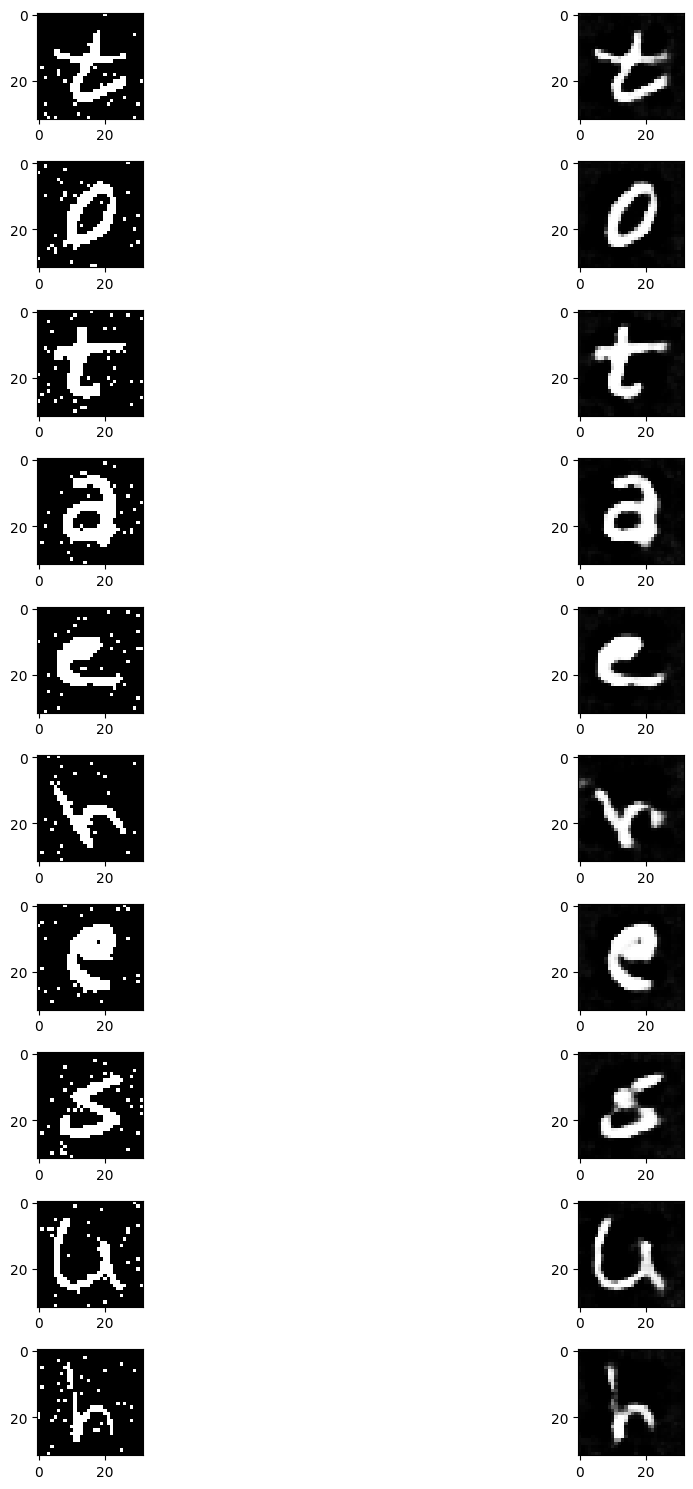

In [48]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 2)
fig.set_size_inches(15, 15)

for i in range(10):
    a = np.random.randint(0, len(emnist_imgs))
    b = np.random.randint(0, emnist_imgs[0].shape[0])
    axs[i][0].imshow(emnist_imgs[a][b].permute(1,2,0), cmap='gray')
    axs[i][1].imshow(emnist_preds[a][b].permute(1,2,0), cmap='gray')

fig.tight_layout()


### Save trained model

In [49]:
import time
epoch_time = int(time.time())

emnist_save_name = str(epoch_time) + "_emnist_" + emnist_Autoencoder.__module__.split('.')[-1] + ".pth"
torch.save(emnist_Autoencoder.state_dict(), 'data/models/' + emnist_save_name)

print('Saved as: ', emnist_save_name)

Saved as:  1672367363_emnist_course_autoencoder.pth


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# KUZUSHIJI

### Load data

In [50]:
kuzushiji_dataset = LettersDataset(sl.load_kuzushiji_pages(trial='trial_4'))

In [51]:
kuzushiji_loader = DataLoader(
    kuzushiji_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,  # 4 * GPU_COUNT
    shuffle=True,
    pin_memory=True
)

### Create model

In [52]:
kuzushiji_Encoder = Encoder(LATENT_WIDTH)
kuzushiji_Decoder = Decoder(kuzushiji_Encoder.latent_width)
kuzushiji_Autoencoder = Autoencoder(kuzushiji_Encoder, kuzushiji_Decoder)

loss_func = F.mse_loss
optimizer = torch.optim.Adam(kuzushiji_Autoencoder.parameters(), lr=LEARNING_RATE) #, lr=LEARNING_RATE)

# Send model to GPU

In [53]:
kuzushiji_Autoencoder.to(device)

Autoencoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, af

# Train model

In [54]:
for epoch in (pbar := tqdm(range(EPOCHS))):

    kuzushiji_Autoencoder.train()

    for batch in kuzushiji_loader:
        images = batch.to(device)
        optimizer.zero_grad()  # MUST be called on every batch
        predictions, latents = kuzushiji_Autoencoder(images)
        loss = loss_func(predictions, images)
        loss.backward()
        optimizer.step()
    pbar.set_postfix_str("Loss: " + str(loss.item()))



100%|██████████| 200/200 [10:38<00:00,  3.19s/it, Loss: 0.05638057738542557] 


### Predict some outputs

In [55]:
kuzushiji_imgs = []
kuzushiji_preds = []

with torch.no_grad() as nograd:
    for batch in tqdm(kuzushiji_loader):

        images = batch.to(device)
        predictions, latents = kuzushiji_Autoencoder(images)
        loss = loss_func(predictions, images)

        kuzushiji_imgs.append(images.cpu())
        kuzushiji_preds.append(predictions.cpu())

100%|██████████| 200/200 [00:02<00:00, 97.40it/s] 


### Check predictions

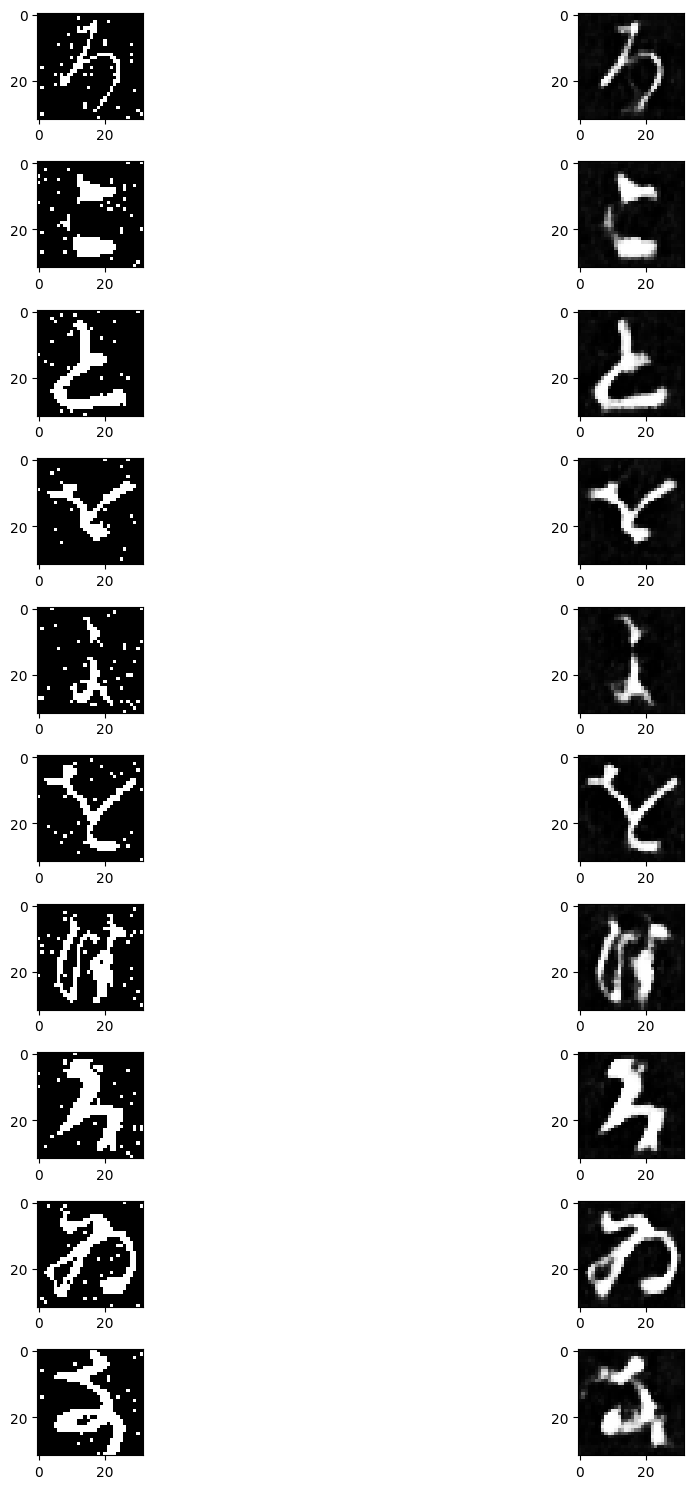

In [56]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 2)
fig.set_size_inches(15, 15)

for i in range(10):
    a = np.random.randint(0, len(kuzushiji_imgs))
    b = np.random.randint(0, kuzushiji_imgs[0].shape[0])
    axs[i][0].imshow(kuzushiji_imgs[a][b].permute(1,2,0), cmap='gray')
    axs[i][1].imshow(kuzushiji_preds[a][b].permute(1,2,0), cmap='gray')

fig.tight_layout()

### Save model

In [57]:
import time
epoch_time = int(time.time())

kuzushiji_save_name = str(epoch_time) + "_kuzushiji_" + kuzushiji_Autoencoder.__module__.split('.')[-1] + ".pth"
torch.save(kuzushiji_Autoencoder.state_dict(), 'data/models/' + kuzushiji_save_name)
print('Saved as: ', kuzushiji_save_name)

Saved as:  1672368015_kuzushiji_course_autoencoder.pth
